# HW04: RDD and Diff-in-Diff (due 24th October 23:59)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [27]:
!pip install rdrobust
!pip install linearmodels

In [28]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [29]:
df = pd.read_stata('data/HW04_data_rdd.dta')

C:\Users\rohit\AppData\Local\Temp\ipykernel_3300\2619628620.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [53]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
for key,value in df_labels.items():
    print(key," : ",value)

uf  :  state
nsorteio  :  Número do sorteio
totrecursos  :  Total de recurso fiscalizado no municipio
tot_os  :  Total de OS fiscalizadas no municipio
pop  :  População no ano de 2000
purb  :  Proporção da população urbana no ano de 2000
p_secundario  :  Proporção da população com 18 anos ou mais com secundario completo
cod_ibge6  :  cod_ibge6
pib_capita_02  :  PIB per capita deflacionado em reais de 2001
op_01_04  :  Dummy se o munic teve orçamento participativo no periodo
reeleito  :  Dummy de reeleição
ENEP2000  :  2000 ENEP
ENLP2000  :  2000 ENLP
pref_idade_tse  :  Idade do prefeito
comarca  :  Sede de Comarca
reeleito_2004  :  Dummy dos candidatos que se reelegeram na eleição de 2004
p_cad_pref  :  Proporção de vereadores eleitos do mesmo partido do prefeito
rec_transf_correntes  :  (mean) rec_transf_correntes
gini_ipea  :  
fiscalizacoes  :  Total ordens de serviço dada pela planilha CGU
valor_fiscalizado  :  Total ordens de serviço dada pela planilha CGU
incumbent  :  (sum) incu

C:\Users\rohit\AppData\Local\Temp\ipykernel_3300\391838989.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


variable translations in English language

1.	uf : state
2.	nsorteio : Number of the draw
3.	totrecursos : Total resources audited in the municipality
4.	tot_os : Total number of OS audited in the municipality
5.	pop : Population in 2000
6.	purb : Proportion of urban population in the year 2000
7.	p_secondary : Proportion of the population 18 years of age or older with completed secondary education
8.	cod_ibge6 : cod_ibge6
9.	pib_capita_02 : GDP per capita deflated in reais of 2001
10.	op_01_04 : Dummy if the municipality had participatory budget during the period
11.	reeleito : Dummy of reelection
12.	ENEP2000 : 2000 ENEP
13.	ENLP2000 : 2000 ENLP
14.	pref_idade_tse : Age of the mayor
15.	comarca : Comarca seat
16.	reeleito_2004 : Dummy of the candidates that were reelected in the 2004 election.
17.	p_cad_pref : Proportion of elected representatives of the same party of the prefeito
18.	rec_transf_correntes : (mean) rec_transf_correntes
19.	gini_ipea :  
20.	fiscalizacoes : Total work orders given by CGU plan
21.	valor_fiscalizado : Total service orders given by CGU plan
22.	incumbent : (sum) incumbent
23.	vereador9600 :  
24.	pmismanagement :  
25.	elected1 :  
26.	first :  
27.	lpib02 :  
28.	lpop :  
29.	pref_masc :  
30.	pref_escola :  
31.	media2 :  
32.	vereador_eleit :  
33.	mun_novo :  
34.	exp_prefeito :  
35.	samepartygov98 :  
36.	lrec_trans :  
37.	lfunc_ativ :  
38.	lrec_fisc :  
39.	ncorrupt :  
40.	value_corrupt :  
41.	pcorrupt :  
42.	dcorrupt :  
43.	esample2 :  
44.	wm : vote margin
45.	winning_margin : running variable
46.	party : party affiliation


--- Translated with www.DeepL.com/Translator (free version)

In [31]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 

<center>$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$</center>

In [36]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col

#Heteroskedasticity-consistent standard errors with degrees of freedom and small-sample adjustment (HC3)
ols1 = smf.ols('pcorrupt ~ first', df).fit(cov_type='HC3') 
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:               pcorrupt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.925
Date:                Sun, 22 Oct 2023   Prob (F-statistic):             0.0481
Time:                        08:43:30   Log-Likelihood:                 415.01
No. Observations:                 476   AIC:                            -826.0
Df Residuals:                     474   BIC:                            -817.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0737      0.007     10.011      0.0

**What could be some sources of bias, namely, variables that act as confounder?**
Some key confounders can be the party, adults with higher education, the mayors are already in and the conducted inspection, which are higher in general indicating revenue generation possibility and hence re-election.

In [62]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols('pcorrupt ~ first + p_secundario + party + fiscalizacoes', df).fit(cov_type='HC3')
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:               pcorrupt   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.126
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           7.85e-06
Time:                        09:19:32   Log-Likelihood:                 431.01
No. Observations:                 476   AIC:                            -820.0
Df Residuals:                     455   BIC:                            -732.5
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0755      0.021      3.642

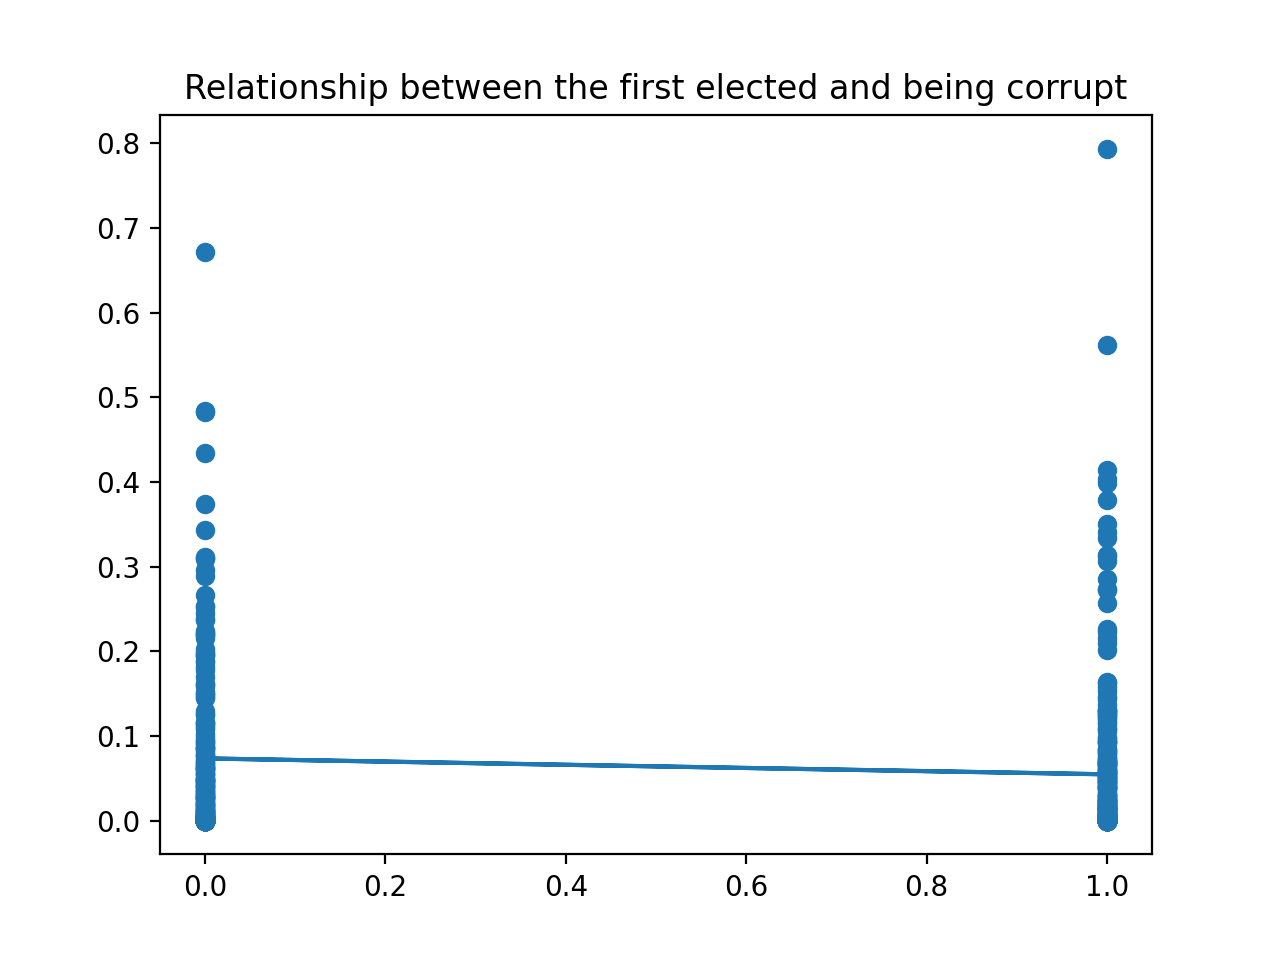

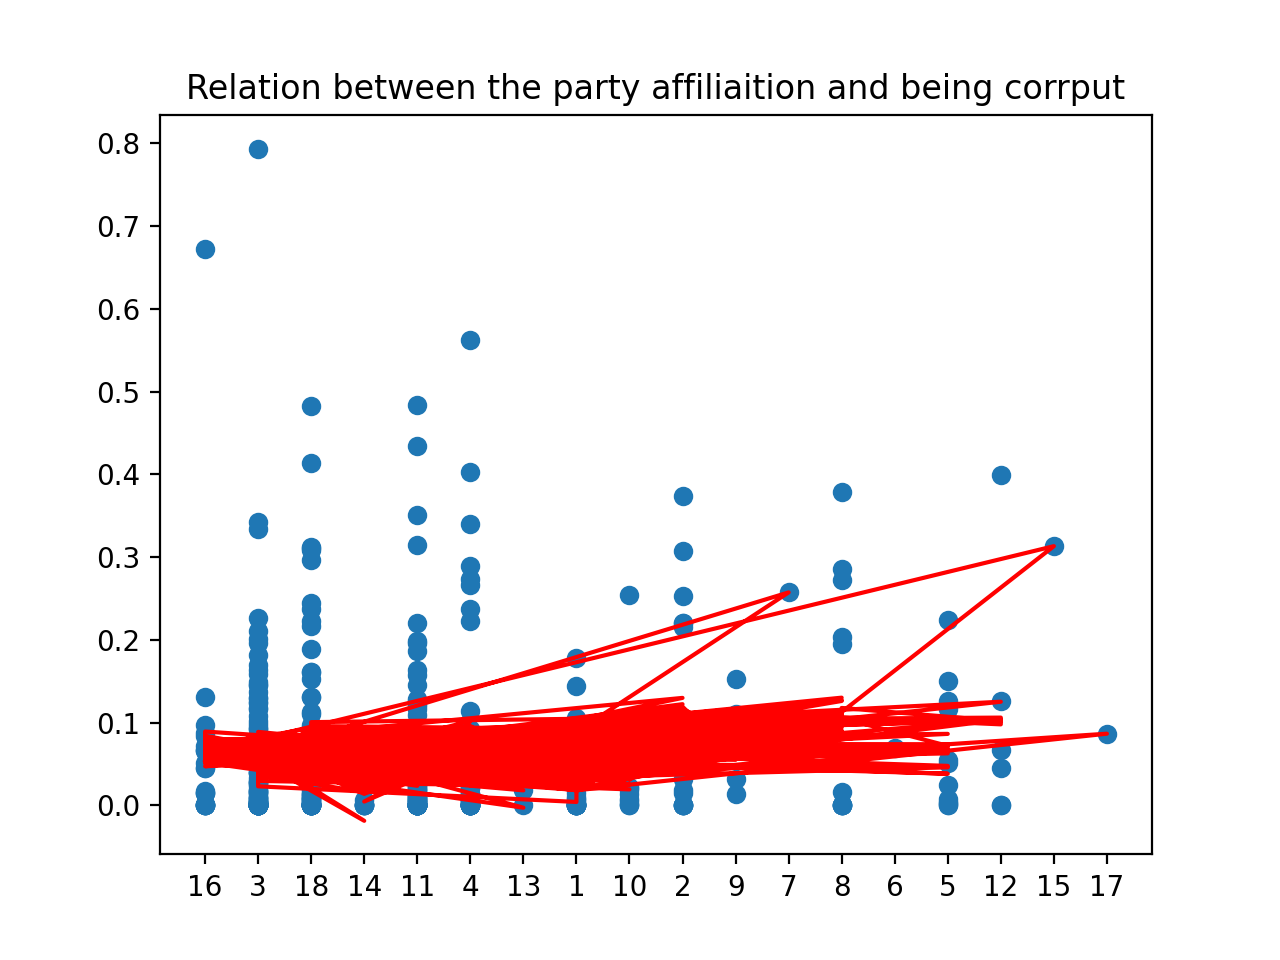

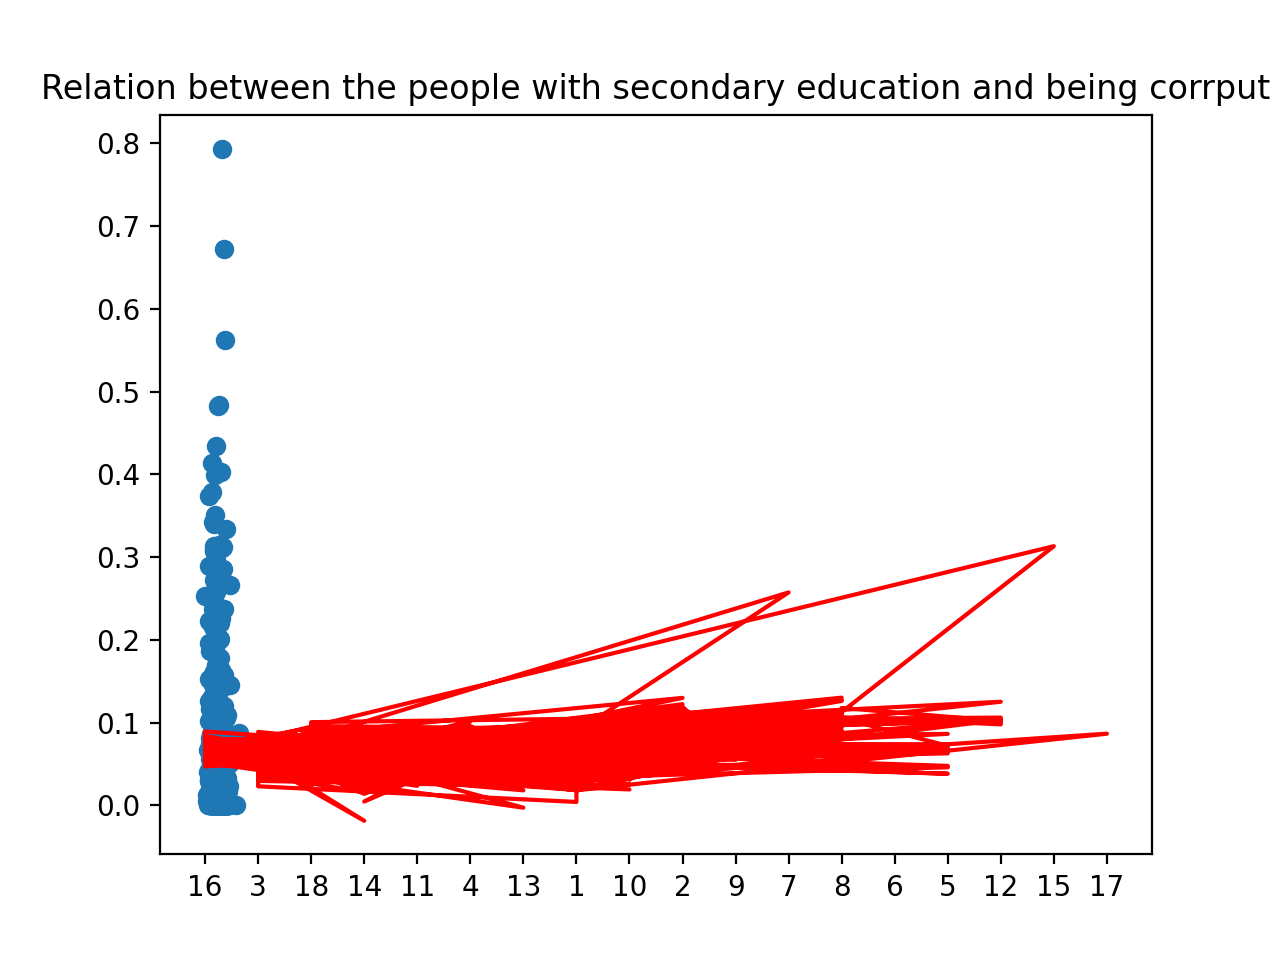

In [64]:
## display the results 
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(df['first'], ols1.predict(df[['first', 'party', 'fiscalizacoes']]))
plt.scatter(df['first'], df.pcorrupt)
plt.title('Relationship between the first elected and being corrupt')
plt.show()

plt.plot(df['party'], ols2.predict(df[['first', 'p_secundario', 'party', 'fiscalizacoes']]), color='red')
plt.scatter(df['party'], df.pcorrupt)
plt.title('Relation between the party affiliaition and being corrput')
plt.show()

plt.plot(df['party'], ols2.predict(df[['first', 'p_secundario', 'party', 'fiscalizacoes']]), color='red')
plt.scatter(df['p_secundario'], df.pcorrupt)
plt.title('Relation between the people with secondary education and being corrput')
plt.show()

In [106]:
#check for any correlation to see the possiblity of confounding variables
variable_of_interest = 'pcorrupt'
correlations = df.iloc[:, 1:].corr()[variable_of_interest]
correlation_df = pd.DataFrame(correlations).reset_index()
correlation_df.columns = ['Variable', 'Correlation']
correlation_df = correlation_df.iloc[correlation_df['Correlation'].abs().argsort()[::-1]]
print(correlation_df)

                Variable  Correlation
39              pcorrupt     1.000000
38         valor_corrupt     0.515233
37              ncorrupt     0.463180
44                 party     0.022590
40              dcorrupt     0.323825
19     valor_fiscalizado     0.284890
25                lpib02    -0.142660
14         reeleito_2004    -0.126084
36             lrec_fisc    -0.123616
22        pmismanagement     0.114183
1            totrecursos    -0.107782
34            lrec_trans    -0.101435
0               nsorteio     0.093788
7          pib_capita_02    -0.092765
9               reeleito     0.091674
24                 first    -0.091674
18         fiscalizacoes    -0.087246
28           pref_escola    -0.085890
16  rec_transf_correntes    -0.082738
5           p_secundario    -0.078041
32          exp_prefeito    -0.071038
21          vereador9600     0.069454
29                media2    -0.066608
2                 tot_os    -0.064433
26                  lpop    -0.064373
15          

**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

Certainly, the existing findings exhibit room for improvement. We have not identified robust confounding factors that exhibit a linear correlation with "pcorrupt." Nevertheless, the inclusion of polynomial terms may potentially enhance our results and establish a more pronounced correlation. Alternatively, we can explore additional variables to discern their impact on the "pcorrupt" variable. However, upon examining the correlaton values, valorcorrupt and ncorrupt can be checkedf further, i could not find any data in the paper yet.

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

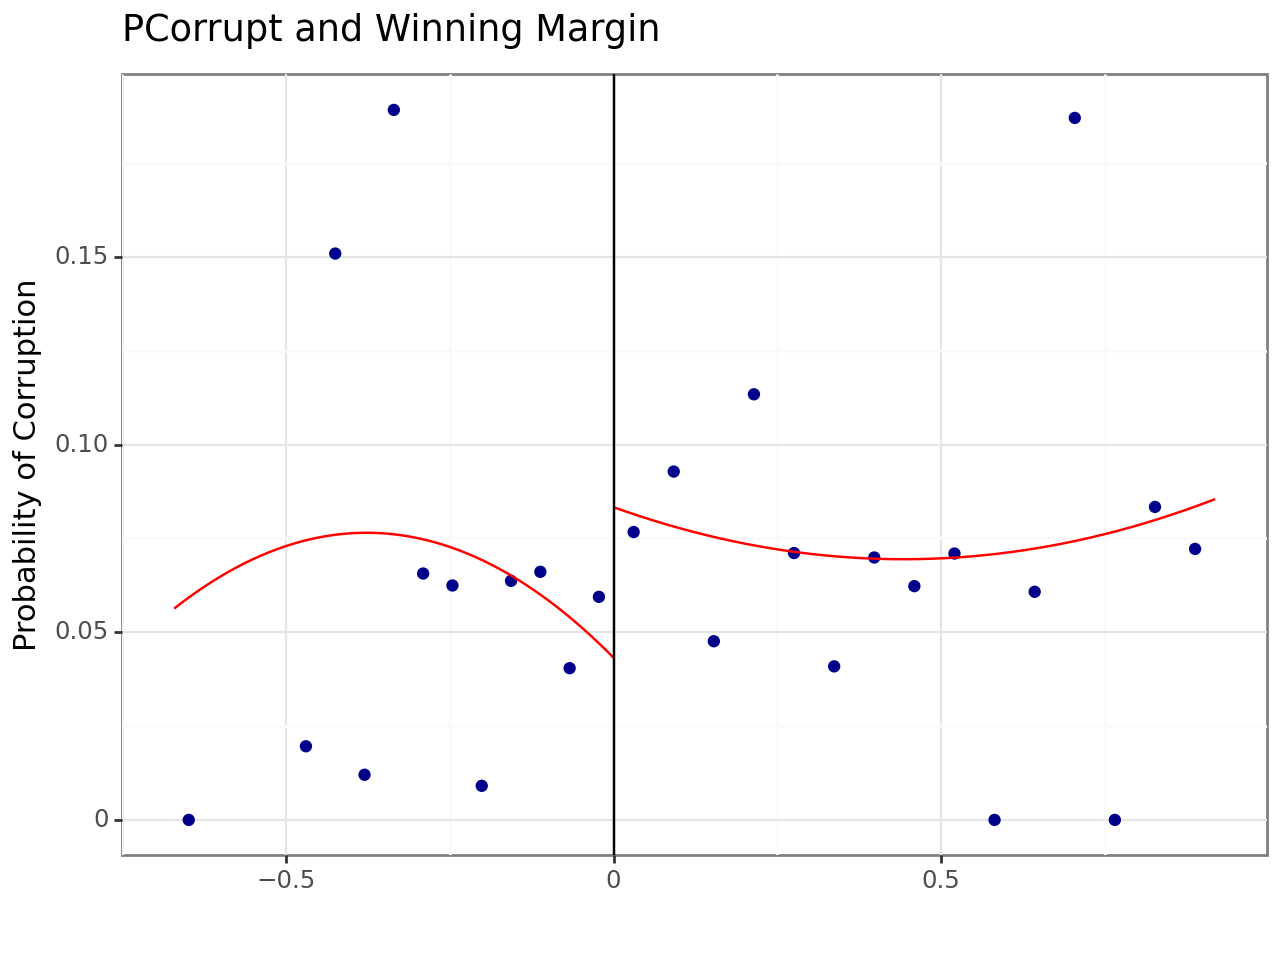


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     15         15
Average Bin Length             0.048      0.061
Median Bin Length              0.045      0.061
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    3.0        5.0
WIMSE variance weight          0.036      0.008
WIMSE bias weight              0.964      0.992


In [108]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt
rdplot(y=corruption, x=margin, p=2, 
       masspoints='adjust', nbins=15,
        title="PCorrupt and Winning Margin", 
         y_label="Probability of Corruption",
         x_label=" ")

In [109]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
covs = pd.concat([df.dropna(subset=['winning_margin'])[['winning_margin']]], axis=1)
print(rdrobust(y=corruption, x=covs, p=4))

Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          94        124
Bandwidth Estimation           0.205      0.205
Bandwidth Bias                 0.274      0.274
rho (h/b)                      0.747      0.747

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        0.03    0.041     0.72   4.717e-01     [-0.051, 0.11]
Robust                 -        -    0.904   3.661e-01    [-0.045, 0.121]



**Interpret the coefficient**

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [183]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
for key,value in df_labels.items():
    print(key," : ",value)

observ  :  block id
barrio  :  neighborhood
calle  :  street
altura  :  street numbering
institu1  :  dummy Jewish institution in the block
institu3  :  dummy Jewish institution one block away
distanci  :  block distance to closest institution
edpub  :  dummy public building/embassy
estserv  :  dummy gas station
banco  :  dummy bank
totrob  :  car theft
mes  :  month
inst3_1  :  
month5  :  
post  :  
inst1p  :  
inst3_1p  :  


C:\Users\rohit\AppData\Local\Temp\ipykernel_3300\540990985.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [184]:
print(df.shape)
df.head()

(7884, 17)


,observ,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,mes,inst3_1,month5,post,inst1p,inst3_1p
0,870.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,851.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,843.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,796.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
4,790.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

<center>$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$</center>

In [185]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = smf.ols('totrob ~ inst1p + institu1', data=df).fit(cov_type="HC3")
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:                 totrob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     16.25
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           9.09e-08
Time:                        11:05:49   Log-Likelihood:                 4.5604
No. Observations:                7884   AIC:                            -3.121
Df Residuals:                    7881   BIC:                             17.80
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0944      0.003     33.680      0.0

**Why this estimate CANNOT be interpreted as causal?**

It is difficult to state why the model cannot be causal. Some indicators could be use of confounding variables. Understanding the study parameters and the subject matter can only provide reason for non-causality.

Simple way to understand model's non-relevance can stated through the low F-Score. Also, the author may not have taken account of incidents before july that influenced events after. 

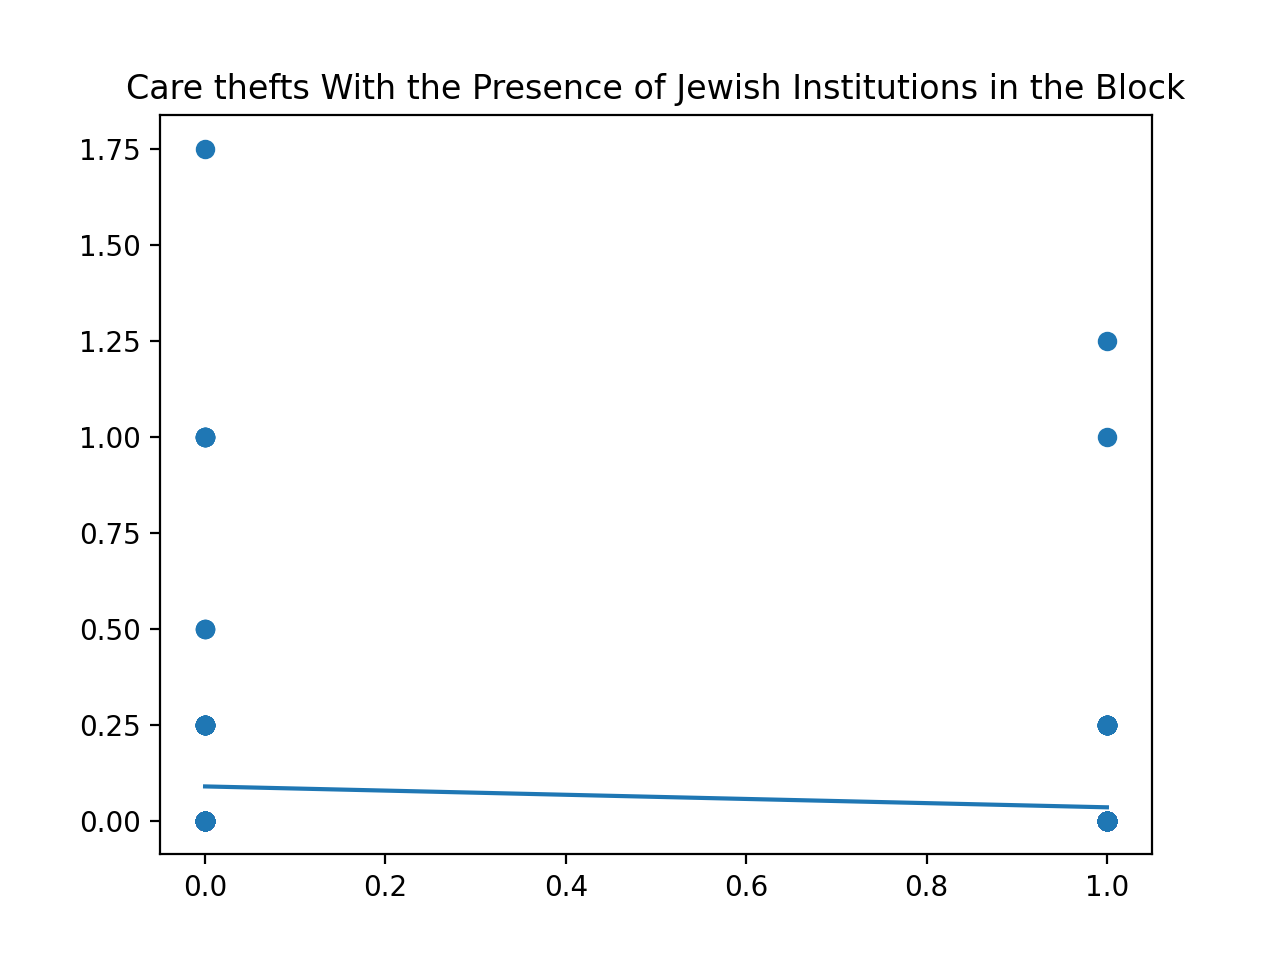

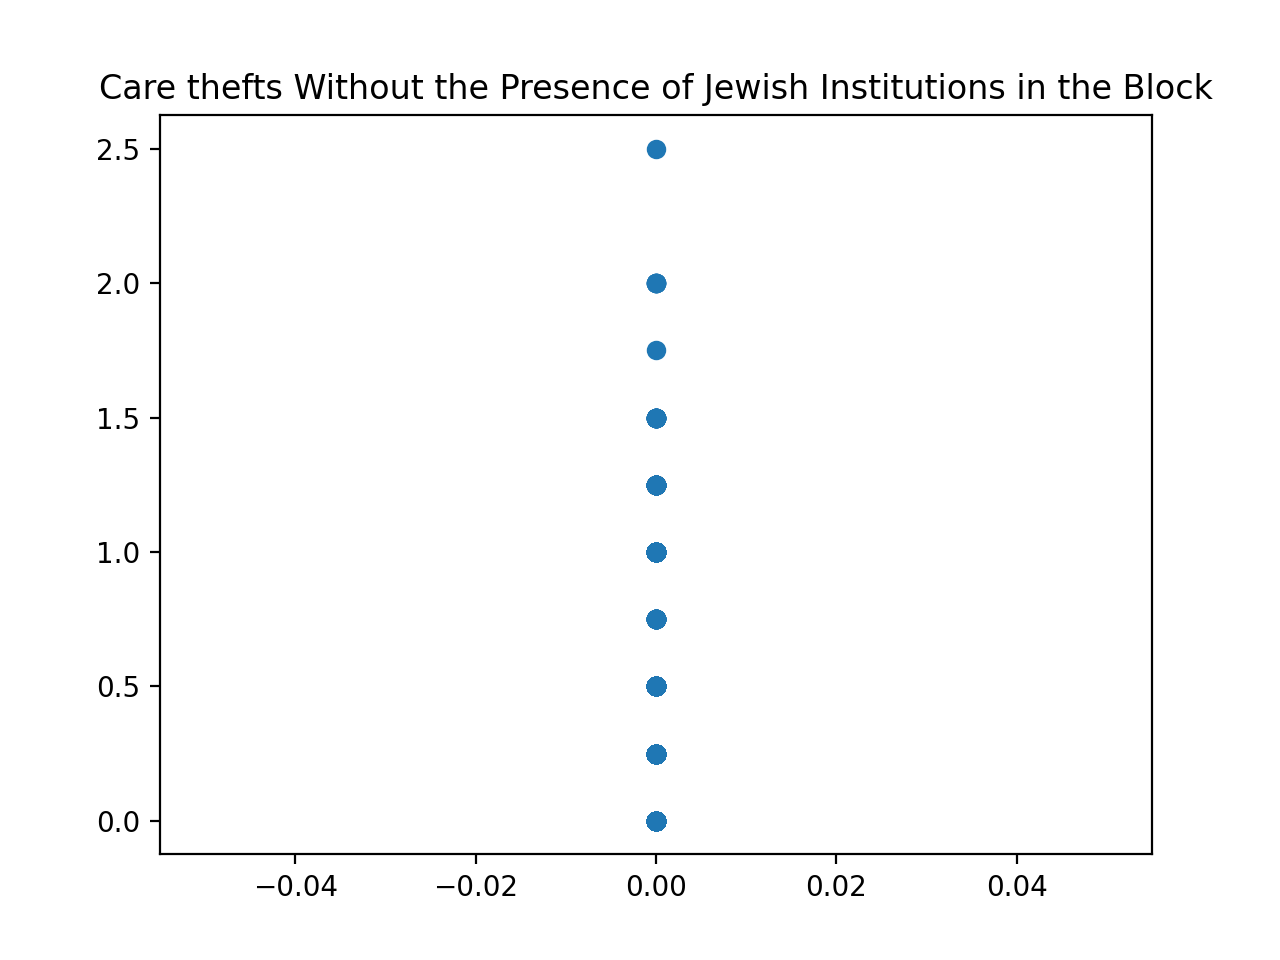

In [186]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
import seaborn as sns
import matplotlib.pyplot as plt

df_yes = df[df['institu1']==1]
plt.plot(df_yes.inst1p, ols1.predict(df_yes[['inst1p', 'institu1']]))
plt.scatter(df_yes.inst1p, df_yes.totrob)
plt.title('Care thefts With the Presence of Jewish Institutions in the Block')
plt.show()

df_no = df[df['institu1']==0]
plt.plot(df_no.inst1p, ols1.predict(df_no[['inst1p', 'institu1']]))
plt.scatter(df_no.inst1p, df_no.totrob)
plt.title('Care thefts Without the Presence of Jewish Institutions in the Block')
plt.show()

**Does the parallel trend assumption hold?**

No, we can clearly see that Jewish blocks hold some affects on the outcome of the robberies.

In [187]:
df_did = df
df_did['place'] = df_did['calle'] + df_did['barrio']
df_did.set_index(['place', 'mes'], inplace=True)
df_did.drop(['calle', 'barrio'], axis=1, inplace=True)
df_did.describe()

,observ,institu1,institu3,distanci,edpub,estserv,banco,totrob,inst3_1,month5,post,inst1p,inst3_1p
count,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.0,7884.000000,7884.000000,7884.000000
mean,438.500000,0.042237,0.226027,3.013699,0.031963,0.020548,0.078767,0.092941,0.183790,0.0,0.555556,0.023465,0.102106
std,252.896606,0.201138,0.418297,2.006882,0.175915,0.141874,0.269391,0.242010,0.387334,0.0,0.496926,0.151383,0.302812
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,219.750000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,438.500000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
75%,657.250000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
max,876.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,2.500000,1.000000,0.0,1.000000,1.000000,1.000000


In [195]:
from linearmodels.panel.model import PanelOLS

# Example data (replace with your actual data)
dependent_variable = df['totrob']
exogenous_variables = df[['inst1p', 'inst3_1p']]

# Create a PanelOLS model with entity effects
model = PanelOLS(dependent=dependent_variable, exog=exogenous_variables, entity_effects=True, time_effects=False, drop_absorbed=True)

# Fit the model
results = model.fit()

# Print the regression results
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 totrob   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):              0.0037
No. Observations:                7884   R-squared (Within):               0.0013
Date:                Sun, Oct 22 2023   R-squared (Overall):              0.0017
Time:                        11:14:17   Log-likelihood                    239.50
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.1961
Entities:                         108   P-value                           0.0056
Avg Obs:                       73.000   Distribution:                  F(2,7774)
Min Obs:                       9.0000                                           
Max Obs:                       207.00   F-statistic (robust):             5.1961
                            

In [196]:
from linearmodels.panel.model import PanelOLS

# Example data (replace with your actual data)
dependent_variable = df['totrob']
exogenous_variables = df[['inst1p', 'inst3_1p']]

# Create a PanelOLS model with time effects
model = PanelOLS(dependent=dependent_variable, exog=exogenous_variables, entity_effects=False, time_effects=True, drop_absorbed=True)

# Fit the model
results = model.fit()

# Print the regression results
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 totrob   R-squared:                        0.0020
Estimator:                   PanelOLS   R-squared (Between):             -0.0450
No. Observations:                7884   R-squared (Within):               0.0004
Date:                Sun, Oct 22 2023   R-squared (Overall):             -0.0068
Time:                        11:14:21   Log-likelihood                    36.255
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.9914
Entities:                         108   P-value                           0.0003
Avg Obs:                       73.000   Distribution:                  F(2,7873)
Min Obs:                       9.0000                                           
Max Obs:                       207.00   F-statistic (robust):             7.9914
                            

**Compare and interpret the results**
In the first model with entity effects, we observe an R-squared (Within) value of 0.0013. This indicates that the independent variables explain a relatively small amount of the within-entity variation in the dependent variable 'totrob.' The F-statistic is 5.1961, with a p-value of 0.0056, suggesting that the model as a whole is statistically significant. Looking at the parameter estimates, 'inst1p' has a coefficient of -0.0496, implying that a one-unit increase in 'inst1p' is associated with a decrease of 0.0496 units in 'totrob.'

In the second model with time effects, the R-squared (Within) value is 0.0004, indicating that the independent variables explain a small amount of the within-time period variation in 'totrob.' The F-statistic is 7.9914, with a low p-value of 0.0003, suggesting that the model is statistically significant. Examining the parameter estimates, 'inst1p' has a coefficient of -0.0716, indicating that a one-unit increase in 'inst1p' is associated with a decrease of 0.0716 units in 'totrob.'

The choice between entity and time effects should be made based on the specific research question and the context of the data. Entity effects capture variation within entities (places), while time effects capture variation within time periods.